<center><h1>EMG-based Estimations of Joints Angles and Torquse Using Long Short-Term Memory Network</center></h1>

## Import libraries

In [2]:
import os
# Move back to the main folder, Make sure to run this cell only at the start
os.chdir('..')

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
tf.random.set_seed(42)
np.random.seed(42)
plt.figure(dpi=100)

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

## define global variables

In [ ]:
features_num=112 #Number of features in the model
out_num=8 # Number of outputs
time_steps=50 # time step for training LSTM model

## Create Pipeline

### getting labels function

In [ ]:
def get_labels():
    """
    Used to get Output labels as a numpy array. Labels are retrived from Subject 1 dataset
    Labels are ['knee_angle_r', 'ankle_angle_r', 'knee_angle_l', 'ankle_angle_l',
            'knee_angle_r_moment', 'knee_angle_l_moment',
            'ankle_angle_r_moment', 'ankle_angle_l_moment']
    Returns
    -------
    list contains all output labels

    """

    output_label =["Right knee angle",  "Right ankle angle","Left knee angle", "Left ankle angle",
                "Right knee torque", "Left knee torque", "Right ankle torque", "Left ankle torque"]
    return output_label

### dataset pipeline

In [ ]:
def get_dataset(subject_no):
    """
    This function is used to retrive the dataset for selected subject. Dataset
    will and last 8 columns contains the output. All columns are labeled.

    Parameters
    ----------
    subject_no : string
    Subject number in format XX.

    Returns
    -------
    pandas dataset
    Subject number "subject_no" dataset without time column

    """
    dataset = pd.read_csv('Dataset/Subject' + subject_no + '_dataset_RMS_MAV_50ms.csv',header=0)
    return dataset.drop(columns="Time").dropna(axis=0)

In [ ]:
def get_scaler(ndarray, features_range=(-1,1)):
    """
    This function is used for creating scalers for scalling the features using
    sklearn.preprocessing.MinMaxScaler function.

    Parameters
    ----------
    ndarray : numpy arrayor pandas dataset
    DESCRIPTION.
    scale_range : Tuple, optional
    Scaling range (Min,Max). The default is (-1,1).

    Returns
    -------
    scaler : MinMaxscaler
    """
    scaler = MinMaxScaler(feature_range=features_range)
    scaler.fit(ndarray)
    return scaler

In [ ]:
def scale_data(dataset, features_range=(-1,1), outputs_range=None):
    """
    Scale input/output using MinMaxScaler. inputs are scaled in range (-1,1)
    and outputs scaled in general model case only using range of (0,1)

    Parameters
    ----------
    dataset : numpy array or pandas
      Dataset to be scaled.
    features_range : tuple
      The scaler range for input features. Default (-1,-1)
    outputs_range : tuple or None
      Scale all outputs in range the desired range. If None, no scaling will
      be performed. Default value is None.

    Returns
    -------
    scaled_dataset : numpy array
      a numpy array contains the scaled dataset.
    output_scaler : MinMaxscaler
      Output values scaler. Optional if Outpus_range is not None

    """
    dataset_values = dataset.values.astype("float32")
    input_scaler = get_scaler(dataset_values[:,:-out_num]) #get scaler for input features
    input_dataset = input_scaler.transform(dataset_values[:,:-out_num]) #scale input features
    if outputs_range==None:
        output_dataset = dataset_values[:,-out_num:]
        scaled_dataset = np.concatenate((dataset_values[:,:-out_num],output_dataset), axis=1)
        return scaled_dataset
    else:
        output_scaler = get_scaler(dataset_values[:,-out_num:], scale_range=outputs_range)
        output_dataset = output_scaler.transform(dataset_values[:,-out_num:])
        scaled_dataset = np.concatenate((dataset_values[:,:-out_num],output_dataset), axis=1)
        return scaled_dataset, output_scaler

In [ ]:
def create_inout_sequences(data_set):
    """
    Create the input and output pairs sequances for the model

      Parameters
    ----------
    input_data : numpy array
        Subject dataset pair (inputs & Ooutputs).
    features : int
        Number of features in our model. default is 112
    out_num : int
        Number of outputs for the model to predict. outputs are arranged same way the get_label() function output.
        default value is 8
    time_steps : int
        Time step for training LSTM model. default value is 50

    Returns
    -------
    features : numpy array
        Numpy array with the shape (len(data_set)-time_step ,time_steps, features) contains the features.
    outputs : numpy array
        Numpy array with the shape (len(data_set)-time_step ,time_steps, out_num) contains all ouputs corrsponding to the features
    """
    features = []
    outputs =  []
    L = len(data_set)
    for i in range(L-time_steps):
        inputs = data_set[i:i+time_steps,:features_num]
        labels = data_set[i:i+time_steps,-out_num:]
        features.append(inputs)
        outputs.append(labels)
    features = np.array(features)
    outputs = np.array(outputs)
    return features,outputs

## Create a function that will process all the pipeline

In [ ]:
def in_out_process(subject, mod="training_set", test_val_size=0.4, features_range=(-1,1), outputs_range=None):
    """
    This function will process the dataset and give us the training, validation and test sets without shuffeling 

    Parameters
    ----------
    subject: an "XX" string format.
    mod: a string that tells the function about the goal of the recieved data set, is it for training or testing. Either "training_set" or "test_set".
    test_val_size: float between [0,1), show the percentage of the validation and test sets from the total data set.
      data will be as follow:
      from 0 to (1-test_val_size)% for training
      from (1-test_val_size)% to (1-test_val_size/2) for validation
      from (1-test_val_size/2)% till the end of the data set for testing
    features_range : tuple
      The scaler range for input features. Default (-1,-1)
    outputs_range : tuple or None
      Scale all outputs in range the desired range. If None, no scaling will
      be performed. Default value is None.

    Returns:
    X_train, X_val, y_train, y_val arrays as float32 tensors if mod is set for "training_set"
    X_test, y_test if mod is set for "test_set"
    """
    # in case of training
    if mod=="training_set":
        # Load the dataset
        dataset = get_dataset(subject)
        # Scale the dataset
        scaled_dataset = scale_data(dataset, features_range=features_range
                                   , outputs_range=None)
        # get features and outputs
        features, outputs = create_inout_sequences(scaled_dataset)
        # get training set
        X_train, X_test_val, y_train, y_test_val = train_test_split(features, outputs,
                                                          test_size = test_val_size,
                                                          random_state=None, shuffle=False)
        # get validation
        X_val, _, y_val, _ = train_test_split(features, outputs,
                                              test_size = test_val_size/2,
                                              random_state=None, shuffle=False)

        print("Dataset_size: %2d, train_size: %2d, test_size: %2d" %(len(features),
                                                                    len(X_train),
                                                                    len(X_val)))

        return tf.constant(X_train,tf.float32), tf.constant(X_val,tf.float32), tf.constant(y_train,tf.float32), tf.constant(y_val,tf.float32)
    # in case of testing
    elif mod =="test_set":
        # Load the dataset
        dataset = get_dataset(subject)
        # Scale the dataset
        scaled_dataset = scale_data(dataset)
        # get test set starting point
        test_len = int((1-test_val_size/2)*len(scaled_dataset))
        # get test set
        X_test = scaled_dataset[test_len: ,:-out_num]
        y_test = scaled_dataset[test_len:,-out_num:]
        return X_test, y_test

## Model creation and Evaluation

### define a function to create the model

In [ ]:
def create_model():
    keras.backend.clear_session() # Make sure we do not have any model in the notebook
    model = keras.Sequential()
    model.add(keras.layers.LSTM(4, return_sequences=True, input_shape=(time_steps, features_num),
                              dropout=0.3 ,name="input_layer"))
    model.add(keras.layers.LSTM(4, return_sequences=True,
                              dropout=0.3, name="2nd_layer"))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(out_num), name="output_layer"))
    model.summary()
    return model

### Model Evaluation function

In [ ]:
def col_arranger(df):
    """
    Arrange columns to match the paper
    """
    DF = df[['Left knee angle', 'Right knee angle', 'Left ankle angle', 'Right ankle angle',
            'Left knee torque', 'Right knee torque', 'Left ankle torque', 'Right ankle torque']]
    return DF

def rmse_cal(Y_pred,Y):
    """
    This function will calculate RMSE values
    """
    size = Y_pred.shape[0]
    rmse_value = np.sqrt(np.sum((Y_pred - Y)**2)/size)
    return rmse_value

def R2_cal(Y_pred,Y):
    """
    This function will calculate R2 scores
    """
    size = Y_pred.shape[0]
    R2_value = 1 - np.sum((Y_pred - Y)**2)/np.sum(Y**2)
    return R2_value
        
#Get the predicted values from the test dataset
def get_prediction(inputs, model):
    """
    get the predictions from inputs
    inputs came in shape (length of the test set, features_num)
    """
    m = len(inputs)
    for i in range(0,m-50,50):
        X = inputs[i:i+50,:]
        X = np.reshape(X,(1,50,112))
        if i == 0:
            Y_preds = model.predict(X) 
        else:
            y_pred = model.predict(X)
            Y_preds = np.concatenate((Y_preds, y_pred))
    return np.reshape(Y_preds,(-1,out_num))

def evaluation(Y, Y_pred, Folder, labels=get_labels()):   
    """
    Evaluate the model and plot the results
    """ 
    time = [i*0.05 for i in range(len(Y_pred))]
    frame_size=len(time)
    r2_score = []
    RMSE_score = []
    for col in range(out_num):
        rmse = np.round(rmse_cal(Y[:frame_size, col], Y_pred[:frame_size, col]),2)
        R2 = np.round(R2_cal(Y[:frame_size, col],Y_pred[:frame_size, col]),4)
        RMSE_score.append(rmse)
        r2_score.append(R2)
        if col == 0 or col == 1 or col == 2 or col == 3:
            y_label = 'Degree'
            unit = '\xB0'
        else:
            y_label = 'Nm'
            unit = ' Nm'
        print('R2_score' + f'({labels[col]}) =', R2)
        print('RMSE' + f'({labels[col]}) = {rmse}' + unit)
        plt.plot(time[:frame_size], Y[:frame_size, col], 'r')
        plt.plot(time[:frame_size], Y_pred[:frame_size, col], 'b--')
        plt.xlabel('Time [s]', fontsize=14)
        plt.xlim((0,30))
        plt.ylabel(y_label, fontsize=14)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        plt.title(labels[col], fontsize="xx-large")
        plt.savefig(Folder + '/' + f'{labels[col]}.pdf')
        plt.show()

    return r2_score, RMSE_score

## Train and Evaluate the model

In [ ]:
def train_eval(subject=None, lr=0.001, test_val_size=0.4,
               load_best=False, eval_only=False, features_range=(-1, 1)):
    """
    This function will train and evaluated the model
    load_best: to load trainable saved model
    eval_only: to skip training process and evaluate the model only, if it set to True, load_best will be True
    """
 
    global Folder, model_path # Create model folder and path and make them global
    Folder = "S" + subject
    if not os.path.exists(Folder): #if folder doesn't exist, create one
        os.makedirs(Folder)
    model_path = Folder + "/S" + subject + '_model.hdf5' # Model path and name

    output_label = get_labels() #import the labels
    if not eval_only: #load dataset for training the model
        X_train, X_val, y_train, y_val = in_out_process(subject, mod="training_set",
                                                        test_val_size=test_val_size, 
                                                        features_range=features_range)

    model = create_model() # Create the model
    try:
        if load_best or eval_only: #load best model if we will evaluate the model only our we want to start training from pre-trained model
            if os.path.exists(model_path): # make sure model exist
                model.load_weights(model_path)
            else:
                pass

          # Train the model
        if not eval_only:
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="MSE") # Create model Compiler
            # Define Check points for saving best model while training
            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( 
            filepath = model_path,
            save_weights_only=True,
            monitor='val_loss',
            save_best_only=True)

            training = model.fit(x=X_train, y=y_train, batch_size=64, epochs=3000,
                              validation_data=(X_val,y_val), 
                              callbacks=[model_checkpoint_callback])
      
            # Plot learning curve after the end of training
            print("\ntrain end\n\n Plotting Learning Curve")
            plt.plot(training.history["loss"][100:])
            plt.plot(training.history["val_loss"][100:])
            plt.title("Model loss")
            plt.ylabel("loss")
            plt.xlabel("epoch")
            plt.legend(["train", "val"], loc="upper left")
            plt.show()

    except KeyboardInterrupt:
        print("\nTrain manually stopped\n\n")

    #Evaluate the model
    # Get test set
    X_test, y_test = in_out_process(subject, mod="test_set", test_val_size=test_val_size, features_range=(-1,1))
    # Get predictions
    y_test_preds = get_prediction(X_test, model)
    # Get R2 and RMSE results and plot measurements against predictions
    r2_score, RMSE_score = evaluation(y_test, y_test_preds, Folder=Folder, labels=output_label)

    # Return results as a pandas dataframe
    r2_score = pd.DataFrame(data=np.array(r2_score,ndmin=2), columns=output_label)
    r2_score.index = {"S" + subject}

    RMSE_score = pd.DataFrame(data=np.array(RMSE_score, ndmin=2), columns=output_label)
    RMSE_score.index = {"S" + subject}
    # arrange columns and get the output
    return col_arranger(r2_score), col_arranger(RMSE_score)

## Train model



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (LSTM)           (None, 50, 4)             1872      
_________________________________________________________________
2nd_layer (LSTM)             (None, 50, 4)             144       
_________________________________________________________________
output_layer (TimeDistribute (None, 50, 8)             40        
Total params: 2,056
Trainable params: 2,056
Non-trainable params: 0
_________________________________________________________________
R2_score(Right knee angle) = 0.985
RMSE(Right knee angle) = 8.43°


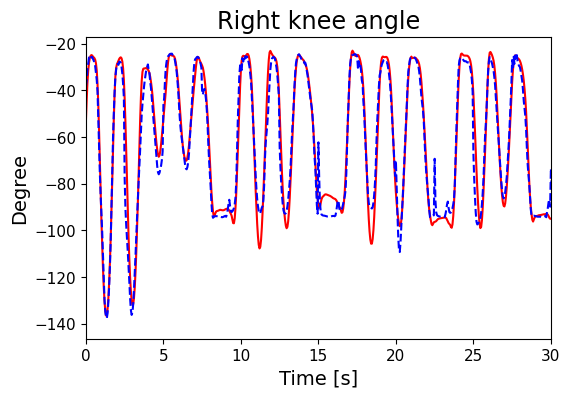

R2_score(Right ankle angle) = 0.9513
RMSE(Right ankle angle) = 3.96°


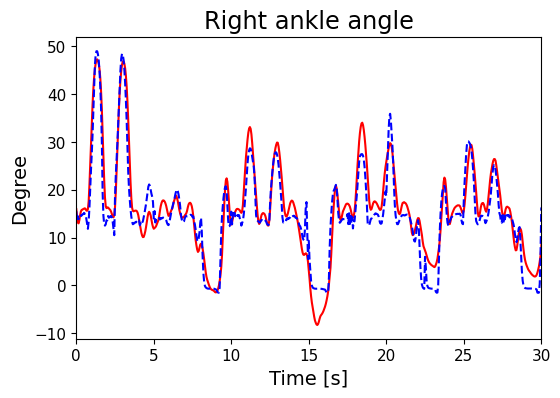

R2_score(Left knee angle) = 0.9847
RMSE(Left knee angle) = 8.5°


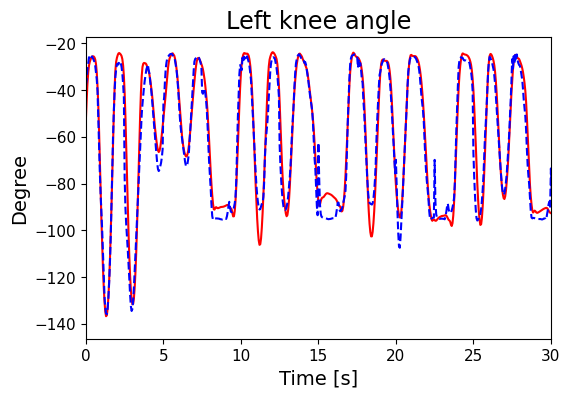

R2_score(Left ankle angle) = 0.9648
RMSE(Left ankle angle) = 3.61°


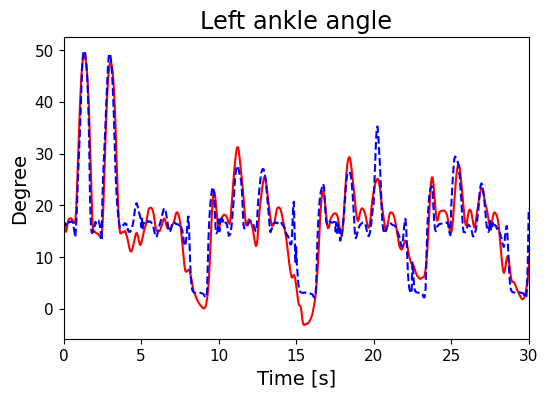

R2_score(Right knee torque) = 0.8863
RMSE(Right knee torque) = 8.08 Nm


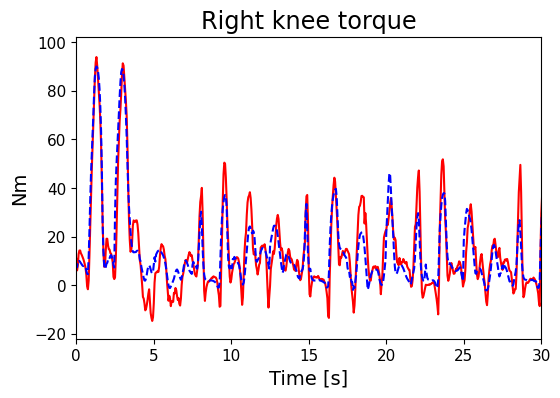

R2_score(Left knee torque) = 0.8546
RMSE(Left knee torque) = 8.53 Nm


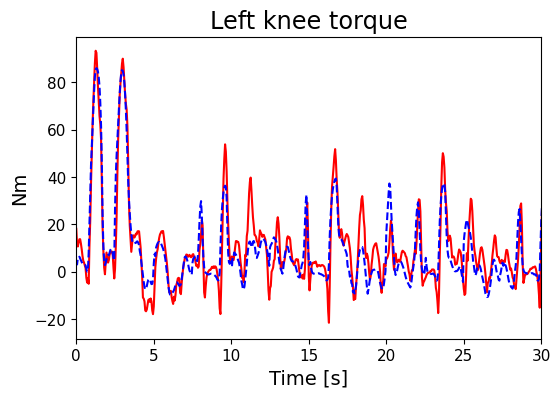

R2_score(Right ankle torque) = 0.9402
RMSE(Right ankle torque) = 6.01 Nm


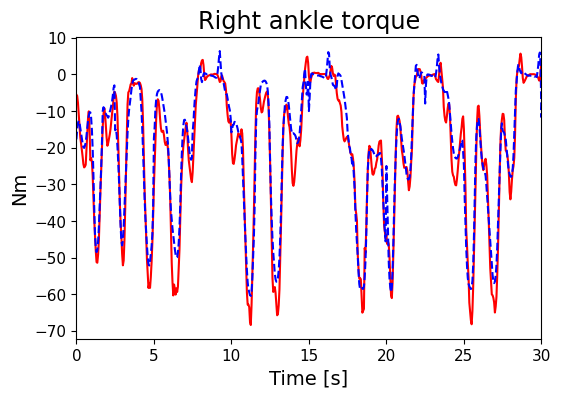

R2_score(Left ankle torque) = 0.9596
RMSE(Left ankle torque) = 6.17 Nm


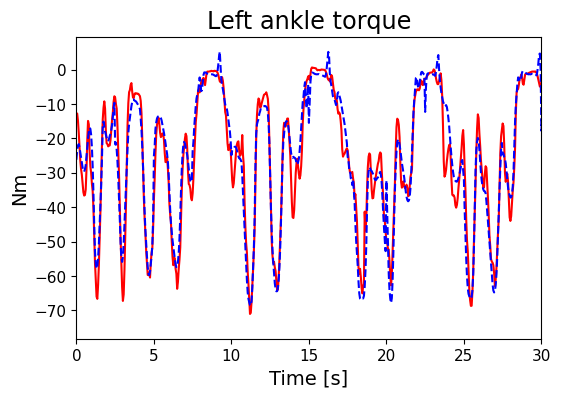

In [ ]:
S1_r2, S1_rmse = train_eval(subject="01", load_best=False, lr=0.001, eval_only=True)

In [ ]:
S1_r2

,Left knee angle,Right knee angle,Left ankle angle,Right ankle angle,Left knee torque,Right knee torque,Left ankle torque,Right ankle torque
S01,0.9847,0.985,0.9648,0.9513,0.8546,0.8863,0.9596,0.9402


In [ ]:
S1_rmse

,Left knee angle,Right knee angle,Left ankle angle,Right ankle angle,Left knee torque,Right knee torque,Left ankle torque,Right ankle torque
S01,8.5,8.43,3.61,3.96,8.53,8.08,6.17,6.01
